In [2]:
# %pip install pydot

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from rasterio.windows import Window
from rasterio.transform import xy
import os
import geopandas as gpd
import glob
import random
import pandas as pd
from rembg import remove
import cv2
import time

## Fusion imports
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model
from keras.utils import normalize

import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dropout
#from keras.layers import CuDNNLSTM
from keras.layers import Dense, Concatenate
import tensorflow as tf
from tensorflow.keras.utils import plot_model


In [4]:
path1 = os.path.abspath('../')
path_ATL03 = os.path.join(path1, "IS2_LSTM")
path_s2 = os.path.join(path1, "S2_tif")
path_csv = os.path.join(path1, "csv")
path_before_training = os.path.join(path1, "Before_training")
print(path_s2)

/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif


# Important functions

In [79]:
# Function to evaluate the model
def evaluate_fusion_model(model, X_test_unet, X_test_lstm, y_test):
    """
    Evaluate model and print classification metrics
    """
    # Get predictions
    y_pred = model.predict([X_test_unet, X_test_lstm])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Calculate and return metrics
    test_loss, test_accuracy = model.evaluate([X_test_unet, X_test_lstm], y_test, verbose=1)
    return test_loss, test_accuracy


def train_fusion_model(
    model,
    X_train_unet,
    X_train_lstm,
    y_train,
    X_val_unet,
    X_val_lstm,
    y_val,
    epochs=50,
    batch_size=32
    ):
    """
    Train the fusion model with validation
    """
    history = model.fit(
        [X_train_unet, X_train_lstm],  # Input data for both branches
        y_train,                        # Target labels
        validation_data=([X_val_unet, X_val_lstm], y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

# Function to plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def color_segmentation(img):
    # Get a "mask" over the image for each pixel
    # if a pixel's color is between the lower and upper white, its mask is 1
    # Otherwise, the pixel's mask is 0
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower_ice = (0, 0, 205)#(127, 7, 94) #increase v to specify ow
    upper_ice = (185, 255, 255)#(147, 53, 232) #increase h to specify si
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    
    lower_tice = (0, 0, 31)#(127, 7, 94) #increase v to specify ow
    upper_tice = (185, 255, 204)#(147, 53, 232) #increase h to specify si
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)
    
    lower_water = (0, 0, 0)#(127, 7, 94) #increase v to specify ow
    upper_water = (185, 255, 30)#(147, 53, 232) #increase h to specify si
    mask_water = cv2.inRange(hsv_img, lower_water, upper_water)
    
    # duplicate the image
    seg_img = img.copy()
    #color each masked portion
    seg_img[mask_ice == 255] = [255, 0, 0]
    seg_img[mask_tice == 255] = [0, 0, 255]
    seg_img[mask_water == 255] = [0, 255, 0]
    
    #seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    
    return seg_img

def shadow_cloud_removal(ori):

    ### seperate open water
    lower_water = (0, 0, 0)
    upper_water = (185, 255, 30)
    hsv_img = cv2.cvtColor(ori, cv2.COLOR_RGB2HSV)
    mask_water = (cv2.inRange(hsv_img, lower_water, upper_water))

    # duplicate the image
    without_water_img = ori.copy()
    without_water_img[mask_water == 255] = [255, 255, 255]
    #plot_image(ori, water_img)

    #img = cv2.imread('s2_vis_2.png',cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(without_water_img, cv2.COLOR_RGB2GRAY)

    dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 155)
    diff_img = 255 - cv2.absdiff(img, bg_img)

    ret2, outs2 = cv2.threshold(src = diff_img, thresh = 0, maxval = 255, type = cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    diff_img2 = cv2.bitwise_and(diff_img, outs2)

    norm_img = cv2.normalize(diff_img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 235, 0, cv2.THRESH_TRUNC)
    thr_img = cv2.normalize(thr_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    ### seperate thin and old ice
    old_thin_ice = cv2.cvtColor(thr_img,cv2.COLOR_GRAY2RGB)
    hsv_img = cv2.cvtColor(old_thin_ice, cv2.COLOR_RGB2HSV)

    lower_tice = (0, 0, 0)
    upper_tice = (185, 255, 204)
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)

    lower_ice = (0, 0, 205)
    upper_ice = (185, 255, 255)
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    mask_ice = cv2.bitwise_xor(mask_water, mask_ice)
    #plot_image3(mask_water, mask_tice, mask_ice)

    # duplicate the image
    shadow_free = old_thin_ice.copy()
    #color each masked portion
    shadow_free[mask_ice == 255] = [255, 255, 255]
    shadow_free[mask_tice == 255] = [155, 155, 155]
    shadow_free[mask_water == 255] = [0, 0, 0]
    shadow_free = cv2.cvtColor(shadow_free, cv2.COLOR_BGR2RGB)
    #plot_image(shadow_free, ori)

    #segmentation
    #img = cv2.cvtColor(water_img,cv2.COLOR_GRAY2RGB)
    seg_img = color_segmentation(ori)
    #plot_image(ori, seg_img, title_1 = "Original Image", title_2 = "Segmented original image")

    #final = cv2.cvtColor(shadow_free,cv2.COLOR_GRAY2RGB)
    seg_res = color_segmentation(shadow_free)
    #gray = cv2.cvtColor(seg_res,cv2.COLOR_RGB2GRAY)
    #plot_image(shadow_free, seg_res, title_1 = "Shadow free Image", title_2 = "Segmented shadow free image")
    
    #return seg_img, shadow_free, seg_res
    return seg_res


def rgba2rgb( rgba, background=(0,0,0)):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

def plot_image(image_1, image_2,title_1="Orignal",title_2="New Image"):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.title(title_2)
    plt.show()


def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision+recall+K.epsilon()))


In [6]:
# Define file paths
tiff_files = ['s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif', 's2_vis_01_20191103T183459_20191103T183502_T05CMS.tif']


# Get list of TIFF files
tiff_files = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

# Get list of CSV files
csv_files = sorted(glob.glob(os.path.join(path_csv, "*.csv")))

# Select two random CSV files
selected_csv_files = random.sample(csv_files, 2)

# ATL03 to S2 mapping file
atl03_to_s2_mapping_file = pd.read_csv(os.path.join(path1, "ATL03_S2_2019-11-01_2019-11-30_ross.csv"))

# Corrected ATL03 to S2 mapping file
cleaned_atl03_to_s2_mapping_file = pd.read_csv(os.path.join(path1, "clean", "cleaned_data_indexed.csv"))

In [7]:
# Show 32x32 Grid Lines (Work on first two files only)
def show_32x32_grid_lines_on_tif_files():
    for file in tiff_files[:2]:
        with rasterio.open(file) as img:
            width, height = img.width, img.height
            transform = img.transform

            # Generate grid lines
            x_coords = np.linspace(0, width, 33)
            y_coords = np.linspace(0, height, 33)

            # Plot grid lines
            plt.figure(figsize=(10, 10))
            plt.imshow(img.read(1), cmap='gray')
            for x in x_coords:
                plt.axvline(x, color='red', linewidth=0.5)
            for y in y_coords:
                plt.axhline(y, color='red', linewidth=0.5)
            plt.title(f'Grid Lines for {os.path.basename(file)}')
            plt.show()


In [8]:

def read_csv_if_exists(file):
    print(file)
    if os.path.exists(file) and os.path.isfile(file):
        return pd.read_csv(file)
    return None

# Function to get coordinates list
def get_coordinates_list(file):
    # Extract the date in YYYYMMDD format from the filename
    date = os.path.basename(file).split("_")[3].split("T")[0]
    dataset = cleaned_atl03_to_s2_mapping_file
    dataset['transformed_date'] = dataset['date'] // 1000000
    # Filter by date and get all unique rows with their original indices
    # df = dataset[dataset['date'] == int(date)].drop_duplicates(subset=['index', 'lat', 'lon'])
    df = dataset[dataset['transformed_date'] == int(date)][['index', 'lat', 'lon']].drop_duplicates(subset=['lat', 'lon'])

    # Create a list of coordinates with their original indices
    coordinates_with_indices = list(zip(df['index'], df['lat'], df['lon']))

    return coordinates_with_indices  # List of (lat, lon, index) tuples



## Images, Grids, coordinates, patches

In [9]:
def create_patches_from_coordinates(file):
    img = rasterio.open(file, crs='EPSG:3976')
    raw = img.read(1)
    raw[raw < 0] = 0

    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0, 1)
    ori = ori.swapaxes(1, 2)

    img_array = ori
    img_array[img_array < 0] = 0
    # mask creation
    copy_img = img.read()
    copy_img[copy_img < 0] = 0
    copy_img = copy_img.swapaxes(0, 1)
    copy_img = copy_img.swapaxes(1, 2)
    mask = shadow_cloud_removal(copy_img)
    mask[mask < 0] = 0

    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    coordinates_list = get_coordinates_list(file)
    df = pd.DataFrame(coordinates_list, columns=['index', 'lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    gdf = gdf.to_crs('epsg:3976')

    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    df = pd.DataFrame(gdf)
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

    # Dimensions for each patch
    patch_size = 100
    half_patch = patch_size // 2

    # List to store the patches
    patches = []
    # List to store the mask patches
    mask_patches = []
    print(f"Number of patches for {file}: {len(pixel_coords)}")
    for idx, (row_idx, col_idx) in enumerate(pixel_coords):  # Using enumerate to get the index
        # Get the corresponding index from the DataFrame
        index = df['index'].iloc[idx]

        # Ensure the 32x32 patch falls within the original image boundaries
        if (row_idx - half_patch >= 0 and row_idx + half_patch < height and 
            col_idx - half_patch >= 0 and col_idx + half_patch < width):

            # Extract the 32x32 patch
            patch = img_array[row_idx - half_patch:row_idx + half_patch, 
                              col_idx - half_patch:col_idx + half_patch]
            patches.append(patch)

            # Extract the mask patch
            mask_patch = mask[row_idx - half_patch:row_idx + half_patch, 
                              col_idx - half_patch:col_idx + half_patch]
            mask_patches.append(mask_patch)

            # Save the patch
            patch_filename = os.path.join(path1, f'grid_images/train/patch_{index}_{row_idx}_{col_idx}.png')
            plt.imsave(patch_filename, patch)
            # Save the mask patch
            mask_patch_filename = os.path.join(path1, f'grid_images/mask/mask_patch_{index}_{row_idx}_{col_idx}.png')
            plt.imsave(mask_patch_filename, mask_patch)

    return patches

# for file in tiff_files:
#     if os.path.basename(file) in ["s2_vis_41_20191120T200529_20191120T200529_T02CME.tif", "s2_vis_46_20191123T183459_20191123T183459_T04CEA.tif"]:
#         print(f"Skipping {file}")
        # create_patches_from_coordinates(file)
    # print(f"Number of patches for {file}: {len(res[0])}")
    # print(f"Number of mask patches for {file}: {len(res[1])}")


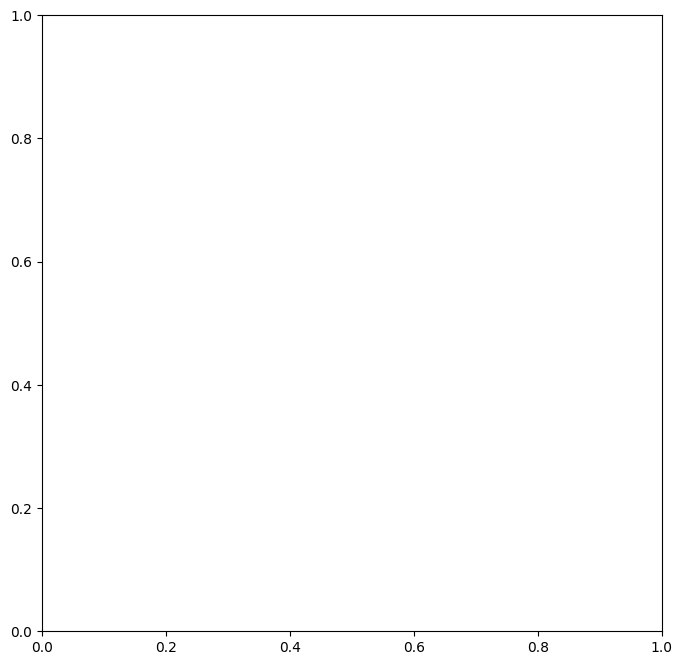

In [10]:
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
# matplotlib.use('TkAgg')
fig, ax = plt.subplots(figsize=(8, 8))

def plot_grid_and_coordinates(file):
    # Open image
    img = rasterio.open(file, crs='EPSG:3976')

    # Read the original image without any processing
    original_img = img.read()
    # Swap axes to get correct orientation (bands last)
    original_img = original_img.swapaxes(0, 2)
    original_img = original_img.swapaxes(0, 1)

    # Get dimensions from original image
    height = original_img.shape[0]
    width = original_img.shape[1]

    # Create coordinate grid
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    # Convert coordinates to GeoDataFrame
    coordinates_list = get_coordinates_list(file)
    df = pd.DataFrame(coordinates_list, columns=['index', 'lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    # Transform to match the image's CRS
    gdf = gdf.to_crs('epsg:3976')

    # Extract transformed coordinates
    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    # Filter coordinates
    df = pd.DataFrame(gdf)
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & 
            (df["y"] >= y_min) & (df["y"] <= y_max)]

    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

    # Generate grid lines
    x_coords = np.linspace(0, width, 33)
    y_coords = np.linspace(0, height, 33)

    # Plot
    plt.imshow(original_img)  # Plot original image without any processing
    plt.vlines(x_coords, 0, height, color='red', linewidth=0.5)
    plt.hlines(y_coords, 0, width, color='red', linewidth=0.5)
    
    rows, cols = zip(*pixel_coords)
    plt.scatter(cols, rows, color='blue', s=2)
    
    plt.title(f'Grid Lines and Coordinates for {os.path.basename(file)}')
    plt.show()


# Plot grid lines and coordinates for the first two files
# for file in tiff_files:
#     if os.path.basename(file) in ["s2_vis_46_20191123T183459_20191123T183459_T04CEA.tif"]:
#         plot_grid_and_coordinates(file)
    # if os.path.basename(file) in ["s2_vis_41_20191120T200529_20191120T200529_T02CME.tif", "s2_vis_27_20191116T184459_20191116T184458_T02CMU.tif"]:
    #     plot_grid_and_coordinates(file)

# UNet batch generator

In [11]:
LIMIT_BATCH_SIZE = 1000
# available indices set
available_indices = set()
train_images_ = []
train_masks_ = []
images_path = os.path.join(path1, "grid_images/train/", "*.png")
images_mask_path = os.path.join(path1, "grid_images/mask")
for filename in sorted(glob.glob(images_path))[:LIMIT_BATCH_SIZE]:
    img = cv2.imread(filename, 0)
    if img is None:
        print(f"Warning: Could not load image {filename}. Skipping.")
        continue
    temp = os.path.basename(filename).split("_")
    index = int(temp[1])
    temp = temp[1:]
    temp = "mask_patch_" + "_".join(temp)
    temp = os.path.join(images_mask_path, temp)
    
    if not os.path.exists(temp):
        continue
    ####################### ####################### ####################### ####################### #######################
    if index in available_indices: # VERY CRUCIAL   ####################### ####################### #######################
        continue
    available_indices.add(index)
    train_images_.append(filename)
    train_masks_.append(temp)
    ####################### ####################### ####################### ####################### #######################


print(f"Number of available indices: {len(available_indices)}")
print(f"Number of train images: {len(train_images_)}")
print(f"Number of train masks: {len(train_masks_)}")

Number of available indices: 835
Number of train images: 835
Number of train masks: 835


### LSTM model

In [48]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Define file paths
output_file = os.path.join(path1, "clean", "cleaned_data_indexed.csv")




# separate features and labels
dataset_accu = pd.read_csv(output_file)
lstm_features = dataset_accu.copy()
# remove rows with index not in available_indices
lstm_features = lstm_features[lstm_features['index'].isin(available_indices)]
lstm_labels = lstm_features.pop('label')
lstm_track = lstm_features.pop('date')
lstm_track = lstm_features.pop('lat')
lstm_track = lstm_features.pop('lon')
print("lstm_features.shape", lstm_labels.shape)


# normalized the features
def norm(x, M = 1, m = 0):
    # Normalize the input data
    # output = (x-m)/(M-m) # Max-min normalization
    output = (x-x.mean())/(M-x.std()) # mean-std normalization
    return output

norm_lstm_features = norm(lstm_features)
norm_lstm_features




# convert the data to LSTM format
np_array = norm_lstm_features.to_numpy()
print(np_array.shape)
new_lstm_features = []
for row in np_array:
  # construct features array
  point_r2 =  row[1:5]
  point_r1 =  row[5:9]
  point_0 = row[9:13]
  point_l1 = row[13:17]
  point_l2 = row[17:21]
  new_lstm_features.append([point_r2, point_r1, point_0, point_l1, point_l2])

new_lstm_features = np.array(new_lstm_features)
print(new_lstm_features.shape) # the X array inputshape = [5,4]



# covert labels to multi-class
def convert_to_multi_calss(data):
  new_labels = []
  for label in data:
    #print(row)
    if label == 0:
      new_labels.append([1,0,0]) 
    elif label == 1:
      new_labels.append([0,1,0])
    elif label == 2:
      new_labels.append([0,0,1])
    else:
      print("Error: invalid label:" + label)
      return 
  return np.array(new_labels)

lstm_labels_multi = convert_to_multi_calss(lstm_labels)
lstm_labels_multi



from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_lstm_features, lstm_labels_multi, 
                                                    test_size =0.2, shuffle=True, random_state=20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size =0.25, shuffle=True, random_state=20)

print("The train set size is {0:d}, validation set size is {1:d}, "
      "and testing set size is {2:d}".format(len(X_train), len(X_val), len(X_test)))

print("The shapes of training data are", X_train.shape, Y_train.shape)

print("The shapes of testing data are", X_test.shape, Y_test.shape)

print("The shapes of testing data are", X_val.shape, Y_val.shape)




units = 32
#loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def get_lstm_model():
    model = Sequential()
    model.add(LSTM(units, activation='elu', input_shape=(5, 4)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))


    sample_weight=np.array([0.10, 0.35, 0.65])

    # Define the optimizer with a specific learning rate
    learning_rate = 0.005
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=sample_weight,
        gamma=2.0,
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction='sum_over_batch_size',
        name='categorical_focal_crossentropy'
    )
    model.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy', f1_m,precision_m, recall_m])
    return model



begin = time.time()
model = get_lstm_model()
history = model.fit(X_train, Y_train, epochs=9, validation_data=(X_val, Y_val), verbose=1)

end = time.time()
print(f"The training time is {end - begin} seconds.")


lstm_features.shape (835,)
(835, 21)
(835, 5, 4)
The train set size is 501, validation set size is 167, and testing set size is 167
The shapes of training data are (501, 5, 4) (501, 3)
The shapes of testing data are (167, 5, 4) (167, 3)
The shapes of testing data are (167, 5, 4) (167, 3)
Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6679 - f1_m: 0.3033 - loss: 0.0477 - precision_m: 0.5887 - recall_m: 0.2455 - val_accuracy: 0.8802 - val_f1_m: 0.8724 - val_loss: 0.0197 - val_precision_m: 0.9017 - val_recall_m: 0.8460
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6574 - f1_m: 0.5874 - loss: 0.0266 - precision_m: 0.6811 - recall_m: 0.5209 - val_accuracy: 0.5569 - val_f1_m: 0.5349 - val_loss: 0.0194 - val_precision_m: 0.7304 - val_recall_m: 0.4226
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6737 - f1_m: 0.6437 - loss: 0.0244 - precision_m: 0.7183 - recall_m: 0.5851 - val_accuracy: 0.8802 - val_f1_m: 0.8772 - val_loss: 0.0175 - val_precis

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - f1_m: 0.7492 - loss: 0.0164 - precision_m: 0.8079 - recall_m: 0.7006
The testing time is 0.05685782432556152 seconds.


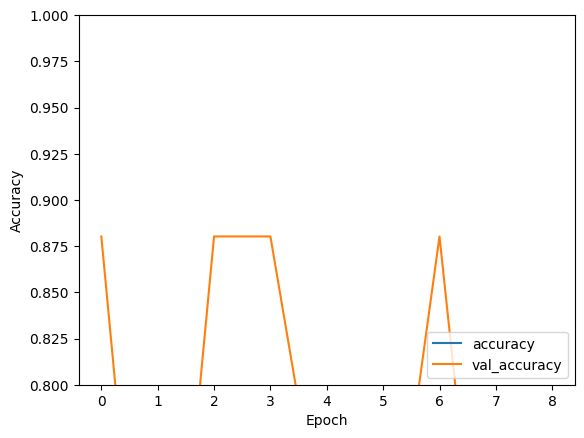

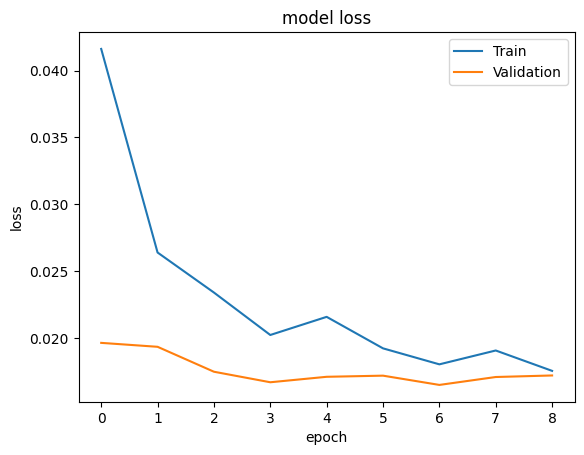

In [49]:
import matplotlib.pyplot as plt
# test the model
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
end = time.time()
print(f"The testing time is {end - begin} seconds.")
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# MMDL Fusion stage

*The MMDL Fusion stage is the final stage of the MMDL pipeline. It takes the predictions of the MMDL models and combines them to produce the final prediction*

#### Preprocessing images for UNet

- [x] Save the UNet model in keras format
- [x] Load the LSTM model in a variable
- [x] Perform additive fusion
- [x] Perform multiplication fusion
- [ ] Perform Gated fusion
- [ ] Perform Nonlinear fusion

In [50]:
# Preparing the data for the fusion model

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #Number of classes for segmentation
path1 = os.path.abspath('../')
path_training_100x100_image = os.path.join(path1, "grid_images/train")
path_mask_100x100_image = os.path.join(path1, "grid_images/mask")
#training image as a list
train_images_list = train_images_
train_images = []


for directory_path in glob.glob(path_training_100x100_image):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        if img_path not in train_images_list:
            continue
        img = cv2.imread(img_path, 0)
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

#Convert list to array for machine learning processing
train_images = np.array(train_images)

#training mask/label as a list
mask_images_list = train_masks_
train_masks = [] 

for directory_path in glob.glob(path_mask_100x100_image):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        if mask_path not in mask_images_list:
            continue
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
#Convert list to array for machine learning processing

train_masks = np.array(train_masks)
print(np.size(train_masks), np.size(train_images))
np.unique(train_masks)
print(train_images.shape, train_masks.shape)
# plot_image(train_images[1], train_masks[1])

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

print("train image shape", train_images.shape)
print("train masks shape", train_masks.shape)

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


print()
print("train image shape", train_images.shape)
print("train masks input shape", train_masks_input.shape)

#################################################
# Here I take only train_masks_input and comment out the rest of the code
#################################################
#Selecting 20% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train_unet, X_test_unet, y_train_unet, y_test_unet = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)

print("Class values in the dataset are ... ", np.unique(y_train_unet))


from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train_unet, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train_unet.shape[0], y_train_unet.shape[1], y_train_unet.shape[2], n_classes))



test_masks_cat = to_categorical(y_test_unet, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test_unet.shape[0], y_test_unet.shape[1], y_test_unet.shape[2], n_classes))


print("X_train_unet train image shape", X_train_unet.shape)
print("X_test_unet train image shape", X_test_unet.shape)
print("y_train_cat shape", y_train_cat.shape)
print("y_test_cat shape", y_test_cat.shape)

# IMG_HEIGHT = X_train.shape[1]
# IMG_WIDTH  = X_train.shape[2]
# IMG_CHANNELS = X_train.shape[3]


54722560 54722560
(835, 256, 256) (835, 256, 256)
train image shape (835, 256, 256)
train masks shape (835, 256, 256)

train image shape (835, 256, 256, 1)
train masks input shape (835, 256, 256, 1)
Class values in the dataset are ...  [0 1 2]
X_train_unet train image shape (668, 256, 256, 1)
X_test_unet train image shape (167, 256, 256, 1)
y_train_cat shape (668, 256, 256, 3)
y_test_cat shape (167, 256, 256, 3)


In [51]:
# delete all rows in lstm data that are not in available_indices
lstm_dataset = dataset_accu.copy()
# size before
# print(lstm_dataset.shape)
lstm_features_synced = lstm_dataset[lstm_dataset['index'].isin(available_indices)]

# separate features and labels
lstm_labels = lstm_features_synced.pop('label')
lstm_features_synced.pop('date')
lstm_features_synced.pop('index')
lstm_features_synced.pop('lat')
lstm_features_synced.pop('lon')
display(lstm_features_synced)

# normalized the features
norm_lstm_features = norm(lstm_features_synced)

new_lstm_features = []
for row in np_array:
  # construct features array
  point_r2 =  row[1:5]
  point_r1 =  row[5:9]
  point_0 = row[9:13]
  point_l1 = row[13:17]
  point_l2 = row[17:21]
  new_lstm_features.append([point_r2, point_r1, point_0, point_l1, point_l2])
new_lstm_features = np.array(new_lstm_features)
#################################################
lstm_labels_multi = convert_to_multi_calss(lstm_labels)
new_lstm_features.shape


,h_cor_mean-2,height_sd-2,pcnth_mean-2,pcnt_mean-2,h_cor_mean-1,height_sd-1,pcnth_mean-1,pcnt_mean-1,h_cor_mean0,height_sd0,pcnth_mean0,pcnt_mean0,h_cor_mean1,height_sd1,pcnth_mean1,pcnt_mean1,h_cor_mean2,height_sd2,pcnth_mean2,pcnt_mean2
10000,0.791500,0.169983,1.000000,6.500000,0.971037,0.070724,3.600000,7.400000,0.888939,0.173739,2.714286,8.571429,0.842807,0.186369,2.000000,7.000000,0.922513,0.082469,1.800000,6.400000
10001,0.971037,0.070724,3.600000,7.400000,0.888939,0.173739,2.714286,8.571429,0.842807,0.186369,2.000000,7.000000,0.922513,0.082469,1.800000,6.400000,0.796576,0.165304,4.166667,6.916667
10002,0.888939,0.173739,2.714286,8.571429,0.842807,0.186369,2.000000,7.000000,0.922513,0.082469,1.800000,6.400000,0.796576,0.165304,4.166667,6.916667,0.754750,0.127537,4.333333,7.333333
10003,0.842807,0.186369,2.000000,7.000000,0.922513,0.082469,1.800000,6.400000,0.796576,0.165304,4.166667,6.916667,0.754750,0.127537,4.333333,7.333333,0.846794,0.108723,5.888889,7.888889
10004,0.922513,0.082469,1.800000,6.400000,0.796576,0.165304,4.166667,6.916667,0.754750,0.127537,4.333333,7.333333,0.846794,0.108723,5.888889,7.888889,0.774610,0.110507,2.333333,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100755,1.129372,0.421474,10.812500,15.468750,0.993524,0.304487,8.583333,14.791667,0.979721,0.299231,7.545455,11.681818,0.957231,0.217913,10.466667,17.200000,1.027464,0.244925,7.454545,10.636364
100756,0.993524,0.304487,8.583333,14.791667,0.979721,0.299231,7.545455,11.681818,0.957231,0.217913,10.466667,17.200000,1.027464,0.244925,7.454545,10.636364,1.003665,0.115406,7.800000,13.400000
100757,0.979721,0.299231,7.545455,11.681818,0.957231,0.217913,10.466667,17.200000,1.027464,0.244925,7.454545,10.636364,1.003665,0.115406,7.800000,13.400000,1.099982,0.224252,7.869565,11.608696
100758,0.957231,0.217913,10.466667,17.200000,1.027464,0.244925,7.454545,10.636364,1.003665,0.115406,7.800000,13.400000,1.099982,0.224252,7.869565,11.608696,1.036100,0.204666,7.545455,12.181818


(835, 5, 4)

#### Load the MMDL models

In [52]:
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Flatten, Multiply, Dense, Input, Reshape, Lambda


# Load the pre-trained UNet model
unet_model = tf.keras.models.load_model('s2_multi_with_cloud_auto_labeled_50.keras')
lstm_model = model



#### Clone the models

In [55]:

# Clone the models with a unique prefix to avoid layer name conflicts
unet_model_cloned = clone_model(unet_model)
unet_model_cloned.set_weights(unet_model.get_weights())
lstm_model_cloned = clone_model(lstm_model)
lstm_model_cloned.set_weights(lstm_model.get_weights())

# Rename layers to avoid conflicts
for layer in unet_model_cloned.layers:
    layer.name = "unet_" + layer.name

for layer in lstm_model_cloned.layers:
    print(layer.name)
    layer.name = "lstm_" + layer.name


lstm_7
dropout_24
dense_34
dropout_25
dense_35
dropout_26
dense_36
dropout_27
dense_37
dropout_28
dense_38
dropout_29
dense_39


## Build the fusion models

### Get input and output layers

In [73]:
"""
To creates the fusion model we need to understand the shapes of our inputs:
- Input of the LSTM model is a 5x4 matrix & is found on the first index of the models layers list.
- Input of the UNet model is a 256x256x1 image (Resized from 100x100)

- To build the fusion, we will extract the features from the last hidden layer of both models.
- We will then flatten the features from the UNet model to match the shape of the LSTM model.
"""

# Get the input layers
unet_input = unet_model_cloned.input
lstm_input = lstm_model_cloned.layers[0].input
# Extract features (fusion layers) from the cloned UNet and LSTM models
unet_features = unet_model_cloned.layers[-2].output  # Last layer before the output
lstm_features = lstm_model_cloned.layers[-2].output  # Last layer before the output

# print the shapes of the features
print("unet output", unet_features.shape)
print("lstm output", lstm_features.shape)

unet output (None, 256, 256, 16)
lstm output (None, 16)


### Center extraction for the UNet and Reshaping of vectors

In [74]:

def extract_center_pixel(x):
    ceter_h = x.shape[1] // 2
    ceter_w = x.shape[2] // 2
    return x[:, ceter_h, ceter_w, :]

# Flatten the vectors and ready the layers in the middle
unet_center = Lambda(extract_center_pixel)(unet_features)  # Shape: (None, 1, 1, 16)
unet_features_flat = Reshape((16,))(unet_center)  # Shape: (None, 16)
print("before flattening unet output", unet_features.shape)
print("after flattening unet output", unet_features_flat.shape)



before flattening unet output (None, 256, 256, 16)
after flattening unet output (None, 16)


### Model for multiplication fusion

In [ ]:

"""
############################################################################################################
###########                      MULTIPLICATIVE FUSION                                         #############        
############################################################################################################
"""

# Multiplicative fusion
multiplicative_fused_features = Multiply()([unet_features_flat, lstm_features])

# Add a dense layer for final classification
x = Dense(64, activation='relu')(multiplicative_fused_features)
multiplicative_output = Dense(3, activation='softmax')(x)
print("Model's output shape", multiplicative_output.shape)

# Create the fusion model
multiplicative_fusion_model = Model(
    inputs=[unet_input, lstm_input],
    outputs=multiplicative_output
)

# Print model's expected input shape and output shape
print("Expected input shape: ", multiplicative_fusion_model.input_shape)
print("Expected output shape: ", multiplicative_fusion_model.output_shape)

# Compile the fusion model
multiplicative_fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# show the model architecture
# plot_model(multiplicative_fusion_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


### Model for additive fusion

In [72]:

"""
############################################################################################################
###########                      ADDITIVE FUSION                                         ###################        
############################################################################################################
"""

# Additive fusion
additive_fused_features = Concatenate()([unet_features_flat, lstm_features])

# Add a dense layer for final classification
x = Dense(64, activation='relu')(additive_fused_features)
additive_output = Dense(3, activation='softmax')(x)
print("Model's output shape", additive_output.shape)

# Create the fusion model
additive_fusion_model = Model(
    inputs=[unet_input, lstm_input],
    outputs=additive_output
)

# Print model's expected input shape and output shape
print("Expected input shape: ", additive_fusion_model.input_shape)
print("Expected output shape: ", additive_fusion_model.output_shape)

# Compile the fusion model
additive_fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# show the model architecture
# plot_model(additive_fusion_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model's output shape (None, 3)
Expected input shape:  [(None, 256, 256, 1), (None, 5, 4)]
Expected output shape:  (None, 3)


### Model for Gated fusion

### Model for Nonlinear fusion

### Final splitting of the data and visualizing the shapes

In [67]:
# print sizes of all train_images, new_lstm_features, lstm_labels_multi
print(train_images.shape) # (835, 256, 256, 1)
print(train_masks_input.shape) # (835, 256, 256, 1) this is the label for the unet model
print(new_lstm_features.shape) # (835, 5, 4)
print(lstm_labels_multi.shape) # (835, 3)

X_train_unet, X_test_unet, X_train_lstm, X_test_lstm, Y_train, Y_test, masks_train, masks_test = train_test_split(
    train_images, new_lstm_features, lstm_labels_multi, train_masks_input, test_size=0.2, random_state=42
)

# print sizes of all X_train_unet, X_test_unet, X_train_lstm, X_test_lstm, Y_train, Y_test
print("Before categorical conversion")
print("X_train_lstm", X_train_lstm.shape) 
print("X_test_lstm", X_test_lstm.shape)
print("Y_train", Y_train.shape) # (668, 3)
print("Y_test", Y_test.shape) # (167, 3)
print("masks_train", masks_train.shape)
print("masks_test", masks_test.shape)
print("Class values in the dataset are ... ", np.unique(masks_train))


from keras.utils import to_categorical
train_masks_cat = to_categorical(masks_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((masks_train.shape[0], masks_train.shape[1], masks_train.shape[2], n_classes))


test_masks_cat = to_categorical(masks_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((masks_test.shape[0], masks_test.shape[1], masks_test.shape[2], n_classes))

print("##########")
print("After categorical conversion")
print("X_train_unet train image shape", X_train_unet.shape) # (668, 256, 256, 1)
print("X_test_unet train image shape", X_test_unet.shape) # (167, 256, 256, 1)
print("y_train_cat shape", y_train_cat.shape) # (668, 256, 256, 3)
print("y_test_cat shape", y_test_cat.shape) # (167, 256, 256, 3)



(835, 256, 256, 1)
(835, 256, 256, 1)
(835, 5, 4)
(835, 3)
Before categorical conversion
X_train_lstm (668, 5, 4)
X_test_lstm (167, 5, 4)
Y_train (668, 3)
Y_test (167, 3)
masks_train (668, 256, 256, 1)
masks_test (167, 256, 256, 1)
Class values in the dataset are ...  [0 1 2]
##########
After categorical conversion
X_train_unet train image shape (668, 256, 256, 1)
X_test_unet train image shape (167, 256, 256, 1)
y_train_cat shape (668, 256, 256, 3)
y_test_cat shape (167, 256, 256, 3)


## Training the fusion models: 

#### Multiplicative Fusion

Given input shape:  [(668, 256, 256, 1), (668, 5, 4)]
Given output shape:  (668, 3)
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.8627 - loss: 0.3055
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step

Classification Report:


NameError: name 'classification_report' is not defined

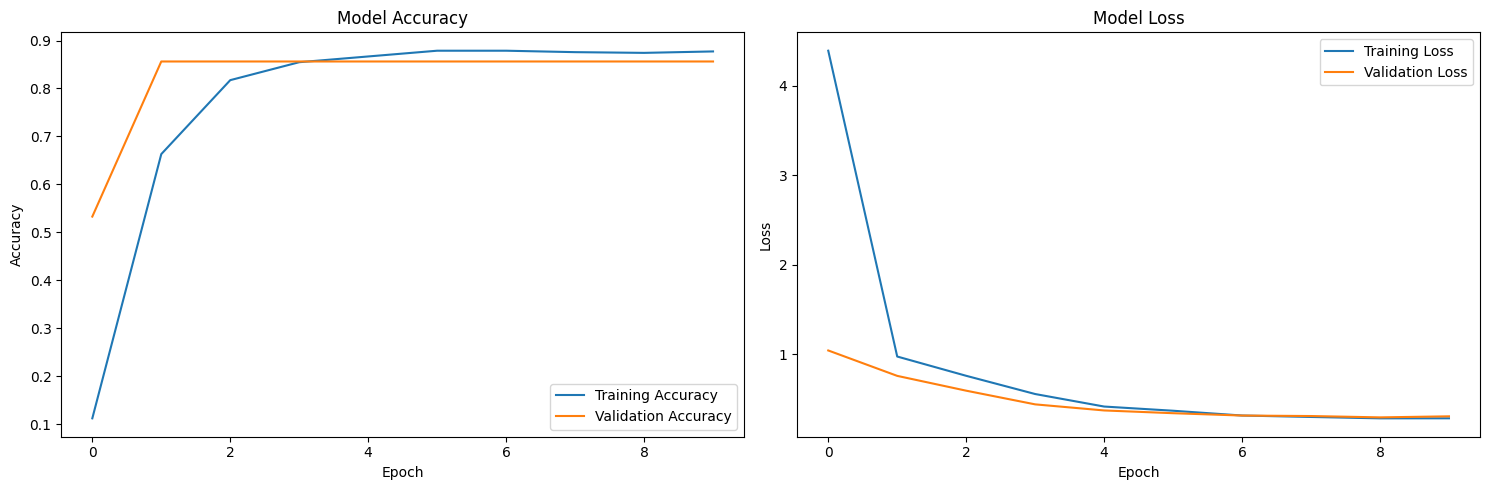

In [80]:

"""
Train the fusion model with the UNet and LSTM features and considering the output of the LSTM and UNet models
"""

print("Given input shape: ", [X_train_unet.shape, X_train_lstm.shape])
print("Given output shape: ", Y_train.shape)

# Train the multiplicative fusion model
# history = train_fusion_model(
#     multiplicative_fusion_model,
#     X_train_unet,
#     X_train_lstm,
#     Y_train,
#     X_test_unet,
#     X_test_lstm,
#     Y_test,
#     epochs=10
# )

# Plot training
plot_training_history(history)

test_loss, test_accuracy = multiplicative_fusion_model.evaluate(
    [X_test_unet, X_test_lstm],
    Y_test,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = evaluate_fusion_model(
    multiplicative_fusion_model,
    X_test_unet,
    X_test_lstm,
    Y_test
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


### Additive Fusion (Concatenation)

In [ ]:
# Train the additive fusion model
history = train_fusion_model(
    additive_fusion_model,
    X_train_unet,
    X_train_lstm,
    Y_train,
    X_test_unet,
    X_test_lstm,
    Y_test,
    epochs=10
)

# Plot training
plot_training_history(history)

test_loss, test_accuracy = additive_fusion_model.evaluate(
    [X_test_unet, X_test_lstm],
    Y_test,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = evaluate_fusion_model(
    additive_fusion_model,
    X_test_unet,
    X_test_lstm,
    Y_test
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


### Technique: Gated Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Create gating mechanisms for both modalities
# The gates are learned weights that control the contribution of each modality
gate_unet = Dense(unet_output.shape[-1], activation='sigmoid')(unet_output)
gate_lstm = Dense(lstm_output.shape[-1], activation='sigmoid')(lstm_output)

# Weight the original outputs by their respective gates
gated_unet_output = Multiply()([unet_output, gate_unet])
gated_lstm_output = Multiply()([lstm_output, gate_lstm])

# Combine the gated outputs
fused_output = Add()([gated_unet_output, gated_lstm_output])

# Add fully connected layers for classification after the fusion
dense1 = Dense(64, activation='relu')(fused_output)
output = Dense(3, activation='softmax')(dense1)  # Assuming 3 classes

# Create the final gated fusion model
gated_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
gated_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
gated_fusion_model.summary()

### Technique: Nonlinear Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Nonlinear fusion: Use a neural network to learn the combination of the two modalities
# Concatenate the features from both modalities
combined_features = Concatenate()([unet_output, lstm_output])

# Pass the concatenated features through multiple dense layers to learn nonlinear interactions
fusion_layer = Dense(128, activation='relu')(combined_features)
fusion_layer = Dense(64, activation='relu')(fusion_layer)
fusion_layer = Dense(32, activation='relu')(fusion_layer)

# Final classification layer
output = Dense(3, activation='softmax')(fusion_layer)  # Assuming 3 classes

# Create the final nonlinear fusion model
nonlinear_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
nonlinear_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Report